# Type Flavor 
Can we figure out what type a card is based on its flavor text?
We will look at the 6 main card types:
- Creatures
- Lands
- Artifacts
- Enchantments
- Instants
- Sorceries

As we embark on this, there are a few things to consider:
- Several cards will have multiple types. For example, "Artifact Creatures" are rather common.
- Instants and Sorceries differ vary little mechanically, and might thus overlap significantly in flavor text as well.
- Unlike colors, card types are not evenly distributed among cards - there are many more creatures in the game than other types. We will need to adjust how we sample our data to address this.

In [1]:
import datetime, os, requests, time
import numpy as np
import pandas as pd
import CF_standard_functions as cf
import pickle as pkl
from matplotlib import pyplot as plt
import seaborn as sns

### Type distributions
Let's start addressing the last point listed above: how many cards of each type are there? Where to card types overlap? \
First let's get our data:

In [2]:
# Set these directories to determine where to save/load the data from:
savepath = "C:\\Users\\gordo\\Documents\\Python Scripts\\Scryfall Projects\\MtG_ClassyFlavor\\"
filename = 'CardData.pkl'
# Directory for getting data from Scryfall:
sf_bulk_url = "https://api.scryfall.com/bulk-data"

if (os.path.isfile(savepath+filename)) and (cf.file_age_in_hours(savepath+filename) < 24):
    print('Loading card data from file...')
    with open(savepath+filename,'rb') as datafile:
        data = pkl.load(datafile)
    print('Done!')
else:
    data = cf.data_from_scryfall()
    print('Saving data locally...')
    with open(savepath+filename,'wb') as datafile:
        pkl.dump(data,datafile)
    print('Done!')
    
print(f"{data.shape[0]} cards with unique flavor text in data set")

Loading card data from file...
Done!
20601 cards with unique flavor text in data set


#### Parsing type lines
The card types are listed in the _type_line_ column with the format _(Supertype) Type1 (Type2) — (Subtype1) (Subtype2) ..._ \
Every card has at least 1 type with optional subtypes listed after an em-dash. Some cards have supertypes (such as "Legendary" or "Basic") which always precede the card types. \
We will parse through this and add a column named _card_type_ which contains only a string of card types. \
Some cards are also "split" cards - two card objects squeezed on to the same piece of cardboard. These are denoted with two slashes "//" in the type line and name. These are a minority of cards, so we will ignore them for now.

In [3]:
# Some examples of split cards:
data['is_split'] = data['type_line'].apply(lambda x : x.find("//") != -1)
data[['name','type_line']][data['is_split']].sample(5)

,name,type_line
77080,Threadbind Clique // Rip the Seams,Creature — Faerie // Instant — Adventure
30033,Young Blue Dragon // Sand Augury,Creature — Dragon // Sorcery — Adventure
27550,Curious Pair // Treats to Share,Creature — Human Peasant // Sorcery — Adventure
10181,Smitten Swordmaster // Curry Favor,Creature — Human Knight // Sorcery — Adventure
42766,Tuinvale Treefolk // Oaken Boon,Creature — Treefolk Druid // Sorcery — Adventure


In [4]:
# Remove split cards:
data = data.drop(data[data.is_split].index)

# Look only for the following card types, removing all subtypes and supertypes:
type_list = ["Creature","Land","Artifact","Enchantment","Instant","Sorcery"]
data['card_type'] = data['type_line'].apply(lambda x : ' '.join(np.intersect1d(x.split(),type_list).tolist()))
data = data.drop(data[data['card_type'] == ''].index)
data['card_type'].value_counts()

# Reindex from 0 for convenience
data = data.reset_index(drop=True)

In [5]:
data['card_type'].value_counts()

Creature                9914
Instant                 2962
Sorcery                 2569
Enchantment             2065
Artifact                1291
Land                     855
Artifact Creature        682
Creature Enchantment      96
Artifact Land             24
Artifact Enchantment       4
Creature Land              1
Name: card_type, dtype: int64

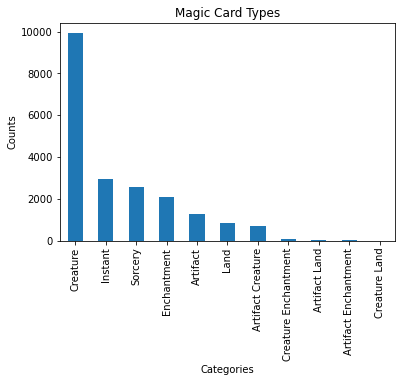

In [6]:
type_counts = data['card_type'].value_counts()
type_counts.plot(kind='bar')
plt.title('Magic Card Types')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

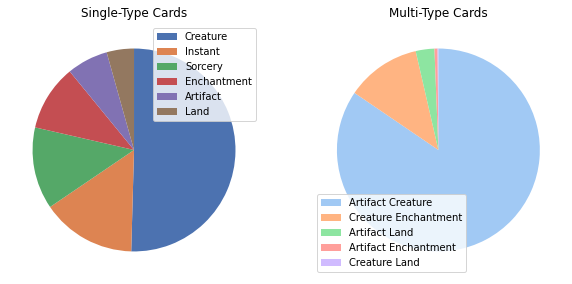

In [7]:
fig,ax = plt.subplots(1,2,sharey=True,figsize=[10,7])
type_counts_mono = data[['card_type']].loc[data['card_type'].isin(type_list)].value_counts()
type_counts_multi = data[['card_type']].loc[~data['card_type'].isin(type_list)].value_counts()
# define Seaborn color palette to use 
ax[0].pie(type_counts_mono,startangle=90,counterclock=False,
       colors = sns.color_palette('deep'))
ax[1].pie(type_counts_multi,startangle=90,counterclock=False,
         colors = sns.color_palette('pastel'))
ax[0].legend(labels = [index[0] for index in type_counts_mono.index])
ax[1].legend(labels = [index[0] for index in type_counts_multi.index])
ax[0].title.set_text('Single-Type Cards')
ax[1].title.set_text('Multi-Type Cards')
plt.show()



Note that the above counts are for our curated list of cards with flavor text and not an exhaustive count of all cards in the game. Cards with multiple unique instances of flavor text are counted multiple times, and cards without flavor text are omitted.

### Now let's set up our model
For now we will only focus on cards with a single card type. Later, we can see how cards with multiple types are classified.
Then we will convert the card type to a numeric categorical variable for our classifier to work with.

In [8]:
data_monotype = data[['name','flavor_text','card_type']].loc[data['card_type'].isin(type_list)]
type_label_map = {i:j for i,j in zip(type_list,range(6))}
data_monotype['label'] = data_monotype['card_type'].map(type_label_map)
data_monotype.head()

,name,flavor_text,card_type,label
0,Fury Sliver,"""a rift opened, and our arrows were abruptly s...",Creature,0
1,Kor Outfitter,"""we take only what we need to survive. believe...",Creature,0
2,Surge of Brilliance,"""they may have superior numbers, but we have s...",Instant,4
3,Venerable Knight,"""may this blade guide you on your great journe...",Creature,0
4,Wildcall,a howl on the wind hides many dangers.,Sorcery,5


Split the data in a stratified way, such that we preserve the frequency of card types across test and train data. \
(Since our data set is large, this is not strictly necessary. Complete random sampling is likely to give us an even distribution of card types. Still, it is a good practice when the groups in our data set are of significantly different sizes).

In [9]:
from sklearn.model_selection import train_test_split

flavor_train, flavor_test, label_train, label_test = train_test_split(
        data_monotype['flavor_text'], data_monotype['label'], 
        test_size=0.5, random_state=41,stratify=data_monotype['label'])

print('Training set consists of',flavor_train.shape[0],'cards.')
print('Test set consists of',flavor_test.shape[0],'cards.')

Training set consists of 9828 cards.
Test set consists of 9828 cards.


#### Design our model
Build a pipeline where we tokenize text and set up our support vector classifier. We will use the same parameters from our grid search in Colorful_Flavor. However, note that we also add a **class_weight** parameter in the LinearSVC, so that we sample our training set inversely proportional to the frequency of our labels.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
my_vectorizer = TfidfVectorizer(min_df = 1,max_df=0.95)
my_linSVC = LinearSVC(C=0.1,class_weight='balanced')
pipe = Pipeline([('vect',my_vectorizer),
               ('clf',my_linSVC)])

pipe = pipe.fit(flavor_train,label_train)

#### Measure model accuracy on test data

In [11]:
label_predict = pipe.predict(flavor_test)
performance = sum(label_predict == label_test) / len(label_test) * 100
print(f"Classifier accuracy is {np.round(performance,1)}%")

Classifier accuracy is 46.0%


              precision    recall  f1-score   support

    Creature       0.60      0.72      0.65      4957
        Land       0.25      0.40      0.31       428
    Artifact       0.29      0.33      0.31       645
 Enchantment       0.19      0.13      0.15      1032
     Instant       0.27      0.18      0.22      1481
     Sorcery       0.22      0.14      0.17      1285

    accuracy                           0.46      9828
   macro avg       0.30      0.31      0.30      9828
weighted avg       0.42      0.46      0.43      9828



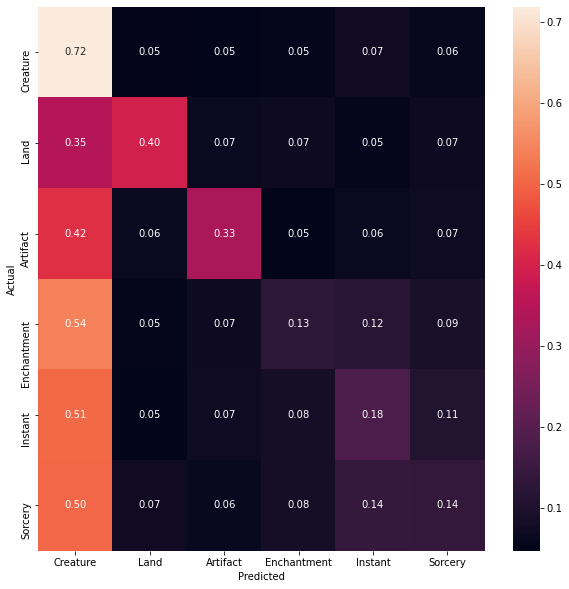

In [15]:
from sklearn import metrics
print(metrics.classification_report(label_test, label_predict,target_names = [str(i) for i in type_label_map]))

cm = metrics.confusion_matrix(label_test, label_predict,normalize='true',
                              labels=list(type_label_map.values()))

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=[str(i) for i in type_label_map],yticklabels=[str(i) for i in type_label_map])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


Oddly, it looks like there is a huge bias towards classifying things as creatures.

For future reference: https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html 